In [1]:
from graph_class import *
from nltk_class import *
from text_mining import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-white')
sns.set_style('white')
update_parameter()

In [2]:
with open('noclean.json', 'r') as file:
    raw_tweet = pd.DataFrame(json.load(file))

dates_from, dates_to = '2021-08-26', '2021-09-08'
raw_tweet = raw_tweet.loc[(raw_tweet.created_at > dates_from) & (raw_tweet.created_at < dates_to)]

print(f'Whole Tweet: {len(raw_tweet)}, from {dates_from} to {dates_to}.')

Whole Tweet: 52684, from 2021-08-26 to 2021-09-08.


In [3]:
nlp = NltkTextProcessing()
tweet_unique = nlp.keep_unique(raw_tweet).reset_index(drop=True)
tweet_unique = nlp.process_df_text_column(tweet_unique, stem=False, min_len=3)
tweet_unique = nlp.process_df_hash_column(tweet_unique)

Tweets including retweets: 52684. Excluded: 13207


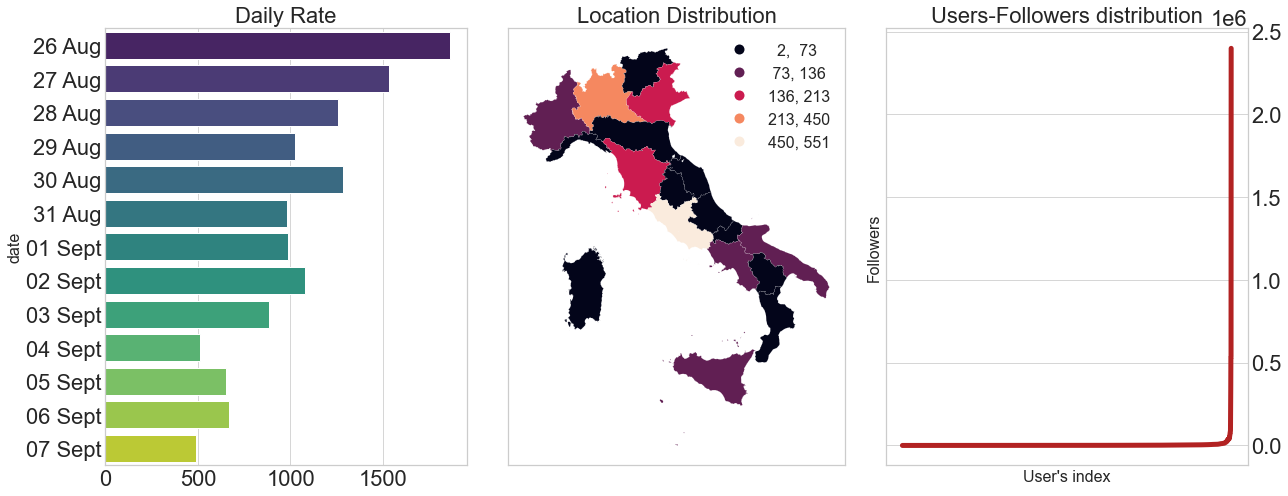

In [4]:
print(f"Tweets including retweets: {len(raw_tweet)}. Excluded: {len(tweet_unique)}")
nlp.plot_dates_location_followers(tweet_unique, save=True)

In [5]:
mining = TextMining()

just_text = tweet_unique.tweet_text.apply(lambda x: ' '.join(x).upper()) #upper
vectorized_text = mining.vectorized_text(just_text.values.tolist()) #sparse matrix
features_name = mining.get_features_names() #names

n_keywords = 1500
filtered_words = mining.extract_topn_from_vector(features_name, mining.sort_coo(vectorized_text), n_keywords)
filtered_words_set = set(map(str.upper, set(filtered_words)))

tokenized_keywords = nlp.take_only_keywords_from_tweets(just_text, filtered_words_set, min_len=2)

Shape of the Sparse Matrix (13207, 26821), type: <class 'scipy.sparse.csr.csr_matrix'>
Keywords founded: 1258
Remained docs: 2907


In [6]:
mining = TextMining() #with filtered tweets

vectorized_text = mining.vectorized_text([' '.join(x) for x in tokenized_keywords])
freq_distrib_tweet = nlp.frequency_dist(tokenized_keywords, obj='mine')

Shape of the Sparse Matrix (2907, 788), type: <class 'scipy.sparse.csr.csr_matrix'>


In [7]:
min_occurencies = 5
main_word_graph =  NetworkPlot.graph_filtered_dist(tokenized_keywords, freq_distrib_tweet, min_occurencies, obj='mine') 

degree_centrality = networkx.algorithms.centrality.degree_centrality(main_word_graph)
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(main_word_graph)
closeness_centrality = networkx.algorithms.centrality.closeness_centrality(main_word_graph)
centrality = [betweeneness_centrality, closeness_centrality, degree_centrality]

print(f"Number of nodes: {len(main_word_graph)}")

Number of nodes: 304


In [8]:
min_node_degree = 4
top_n_centrality_word = 40

graph_min_degree = NetworkPlot.keep_minimun_degree(main_word_graph, min_node_degree)
top_words_min = NetworkPlot.get_set_top_centrality_words(centrality, top=top_n_centrality_word)
top_words_extended = NetworkPlot.extend_top_word(graph_min_degree, thresold=20, res=top_words_min)
NetworkPlot.keep_connected_components(graph_min_degree, min_degree = 10)

k = [2, 3, 5, 7, 9, 10, 15, 20, 25, 30, 50, 65]
best_cluster_k = NetworkPlot.find_best_k_and_cluster(graph_min_degree, k=k, gamma=None)
best_cluster_k[3], best_cluster_k[4], len(top_words_min), len(top_words_extended)


(((3, 0.2506624868069163), None), ((3, 0.16236826824714237), None), 44, 60)

In [24]:
n_cluster, k, gamma = 3, 3, 5
cluster, cluster_label = NetworkPlot.spectral_clustering(graph_min_degree,n_cluster=n_cluster, w='count', k=k)
to_plot = NetworkPlot(graph_min_degree, freq_distrib_tweet, labels = cluster_label)

Cluster distribution: [13, 197, 92], Silhouette Score: 0.2506624868069163


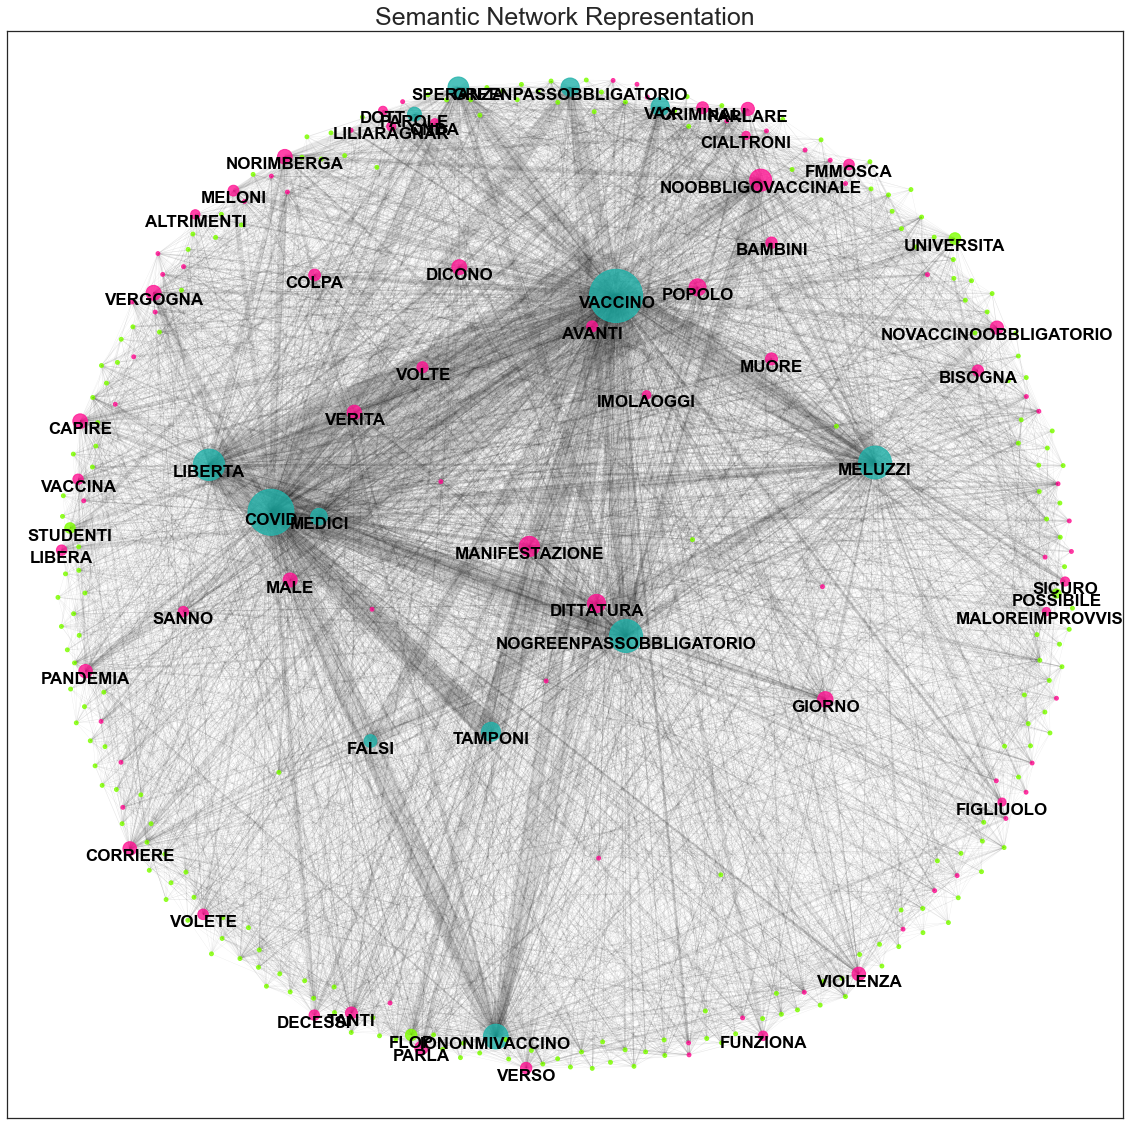

In [83]:
colors = ['lightseagreen', 'chartreuse', 'deeppink']
to_plot.plot_main_centrality(top_words_extended, 
                             mul_factor=3, 
                             save='graphs2', 
                             k=5.35, 
                             i=100, 
                             w=None, ka=False, 
                             c=colors)

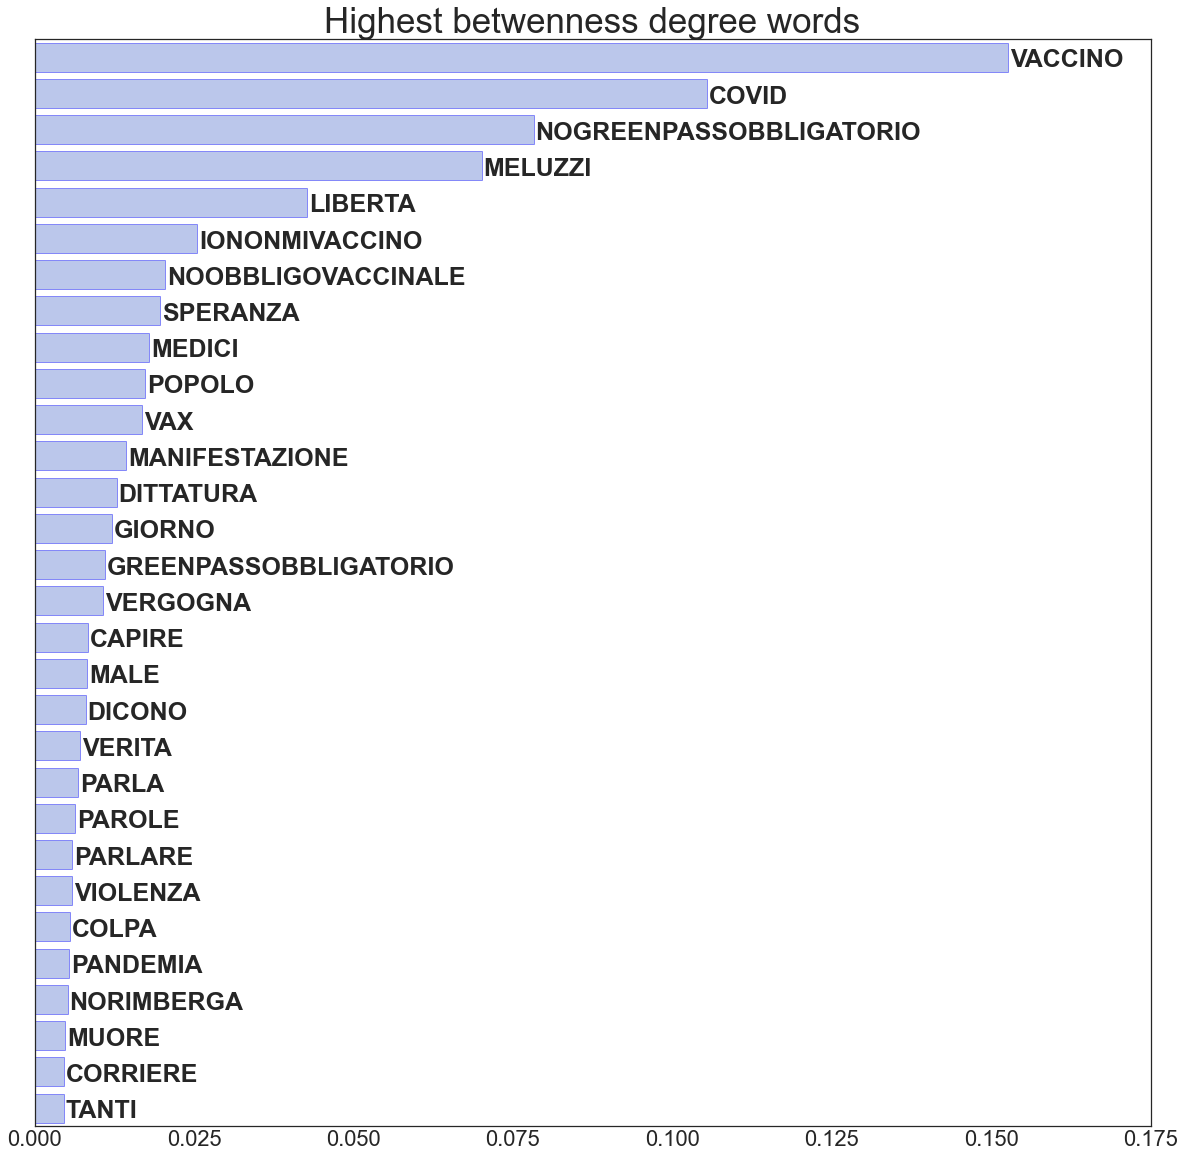

In [11]:
NetworkPlot.count_barplot(centrality[0], 
                          name='centrality', title='Highest betwenness degree words', 
                          to=30, ticks=np.arange (0, 0.20, 0.025), save=True)

In [13]:
too_common = ['VACCINO','COVID']
for i in tokenized_keywords:
    for j in too_common: 
        if j in i: i.remove(j)
vectorized_text = mining.vectorized_text([' '.join(x) for x in tokenized_keywords])

Shape of the Sparse Matrix (2907, 786), type: <class 'scipy.sparse.csr.csr_matrix'>


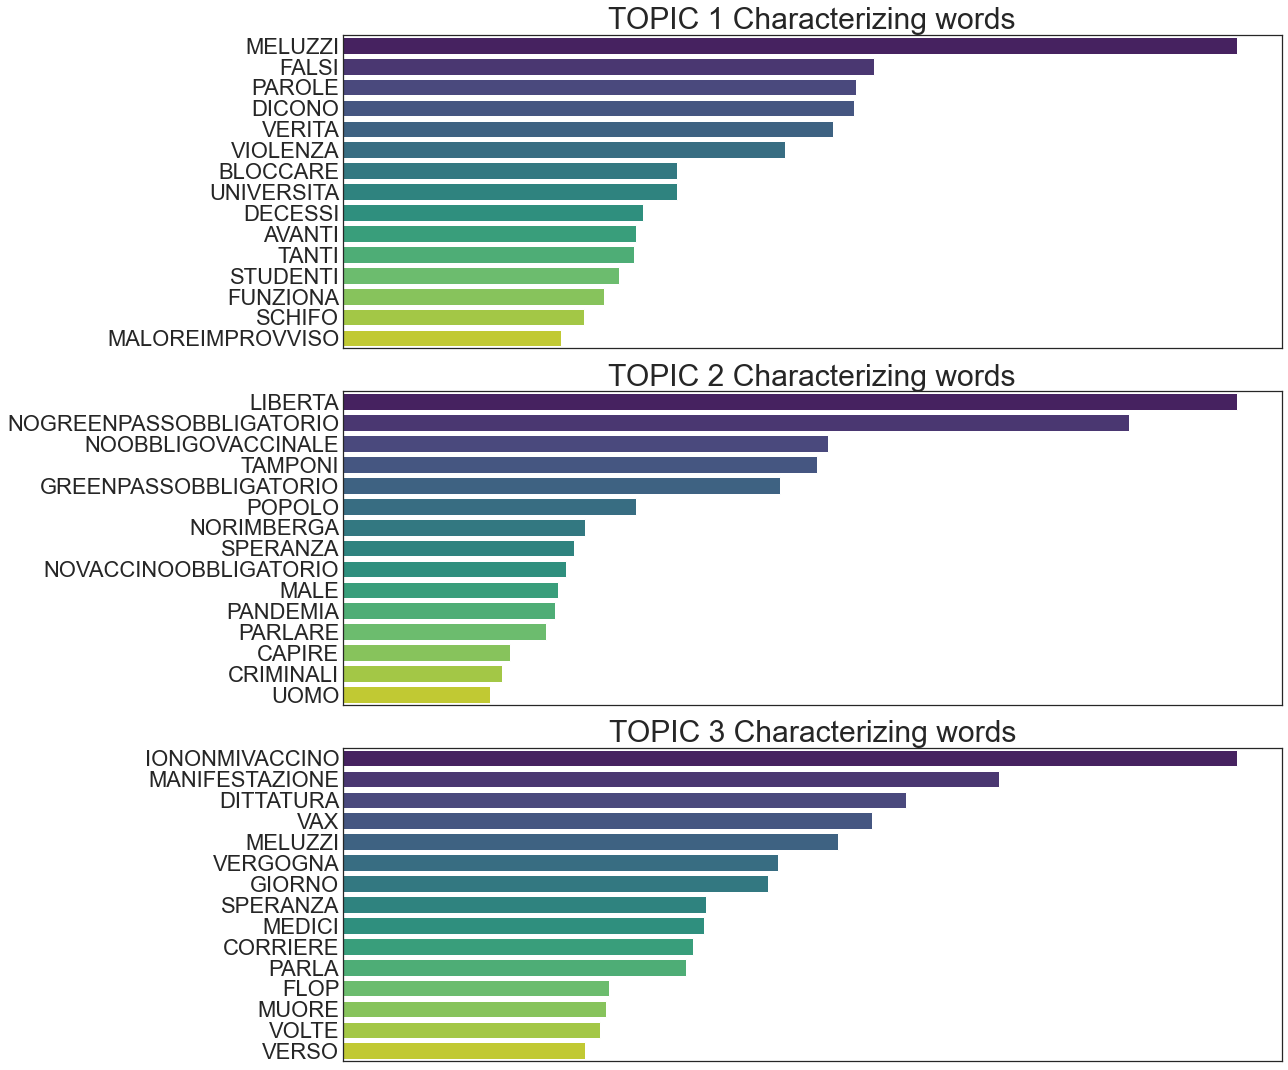

In [14]:
topics, top_word = 3, 15
lda_model = mining.lda_topic_modeling(vectorized_text, topics) # count_vector?
mining.plot_lda_topic(lda_model, topics, n_top_words=top_word, save=True)

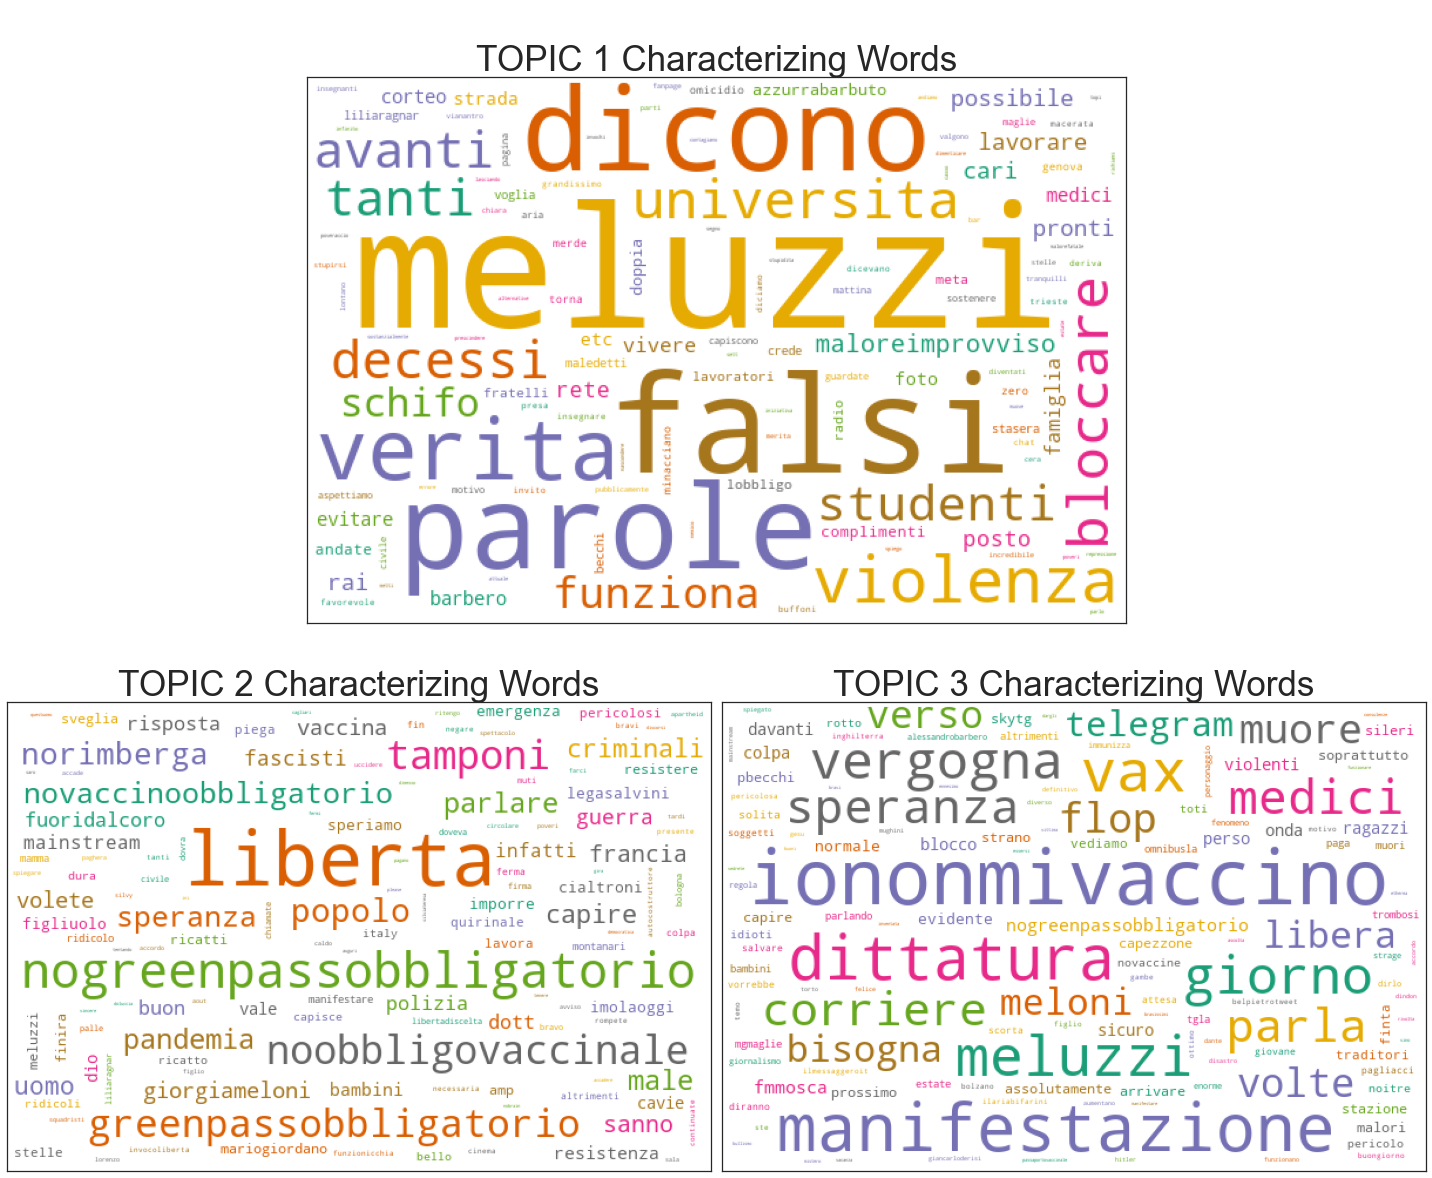

In [15]:
bag_of_words = mining.word_cloud_dict(lda_model)
mining.plot_wordcloud(bag_of_words, n_topics=3, save='lda-topics', palette='Dark2_r')

In [ ]:
NetworkPlot.count_barplot(nlp.extract_external_url(raw_tweet),
                          name='countplot', title='Most Frequent External URL', 
                          to=30, ticks=[i for i in range(0, 450, 25)], r=True,
                          save=False, h=15, w=20, )

In [16]:
k = 11
sparse_mat = networkx.to_numpy_matrix(graph_min_degree, weight ='count')
umap_reduced = pd.DataFrame(mining.umaps(sparse_mat, k=k), columns=[f'Component {i + 1}' for i in range(2)]) 
umap_reduced['labels'] = list(graph_min_degree.nodes())

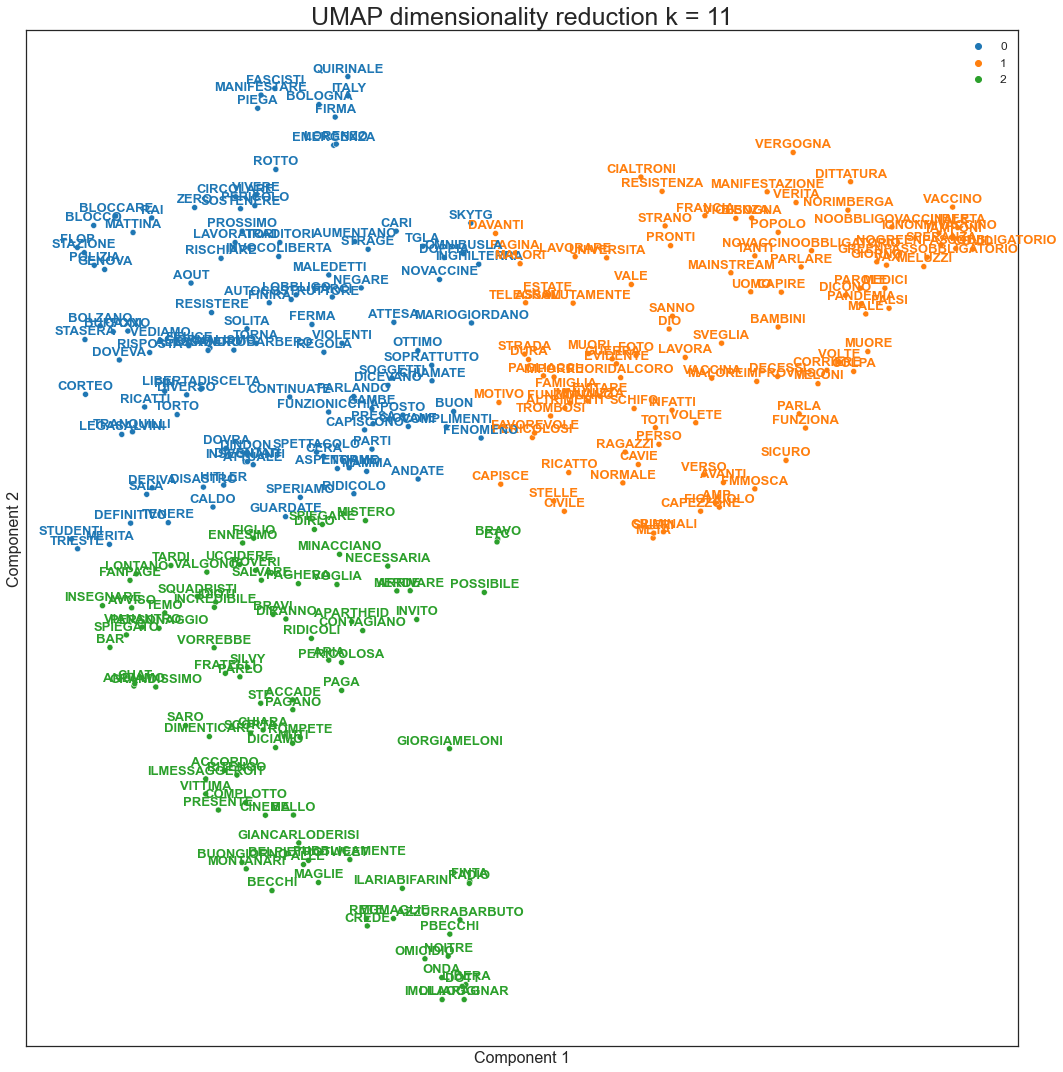

In [18]:
mining.plot_umaps(umap_reduced, n_cluster=3, k=k, palette='tab10', save='umap', l=13)